In [1]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import AutoModel, AutoTokenizer, get_scheduler
from torch.optim import AdamW
from accelerate.utils import set_seed
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re
from sklearn.svm import SVC

In [44]:
train = pd.read_csv('/kaggle/input/gold-dataset/train_data.csv', sep=',')

In [45]:
test = pd.read_csv('/kaggle/input/gold-dataset/test_data.csv', sep=',')

In [46]:
train.head()

,Unnamed: 0,BID_PRICE,CONTENT,DATE,PRICE,TIME,TITLE,labels
0,694,74.00,Chuyên gia nhận định các yếu tố đang nghiêng v...,15/01/2024,77.00,08:30,Giá vàng hôm nay 15/1: Vàng sẽ tăng lại mức đỉ...,increase
1,638,70.10,Giá vàng giằng co trước những diễn biến khó đo...,02/11/2023,70.80,08:30,"Giá vàng hôm nay 2/11: Đón tin xấu, giá vàng d...",decrease
2,133,54.10,Giá vàng hôm nay ngày 02/12: Sau nhiều diễn bi...,02/12/2020,54.75,08:30,Giá vàng hôm nay ngày 02/12: Giá vàng đột ngột...,increase
3,355,69.55,. Giá vàng năm châu không ngừng cắm đầu lao dố...,20/04/2022,70.25,08:55,"Giá vàng hôm nay 20/4: Hụt hơi, vàng quay đầu ...",decrease
4,55,60.60,Giá vàng lúc 9h34 ngày 7/8/2020 tiếp tục lập đ...,07/08/2020,62.20,10:10,Giá vàng ngày 7/8/2020: lập đỉnh mới trên 62 t...,increase


In [47]:
test.head()

,Unnamed: 0,BID_PRICE,CONTENT,DATE,PRICE,TIME,TITLE,labels
0,595,67.50,“Ngay cả khi vàng và bạc không tăng giá thì ch...,29/08/2023,68.10,09:00,Giá vàng hôm nay 29/8: USD suy yếu giúp vàng b...,increase
1,587,67.00,Hầu hết các nhà phân tích đều cho rằng giá vàn...,19/08/2023,67.70,08:20,"Giá vàng hôm nay 19/8: Áp lực bủa vây, vàng ch...",decrease
2,543,66.35,Nhà phân tích thị trường cấp cao Edward Moya c...,28/06/2023,66.95,14:15,"Giá vàng hôm nay 28/6: Tiếp tục đi xuống, có n...",decrease
3,644,69.30,"Hiện tại, thị trường đang chờ đợi bài phát biể...",10/11/2023,70.30,08:35,Giá vàng hôm nay 10/11: Tăng nhẹ chờ thời,decrease
4,487,66.65,Giá vàng đã có lúc giảm sâu xuống ngưỡng 1.944...,28/03/2023,67.35,09:05,"Giá vàng hôm nay 28/3: Dân buôn chốt lời, vàng...",decrease


In [48]:
def get_config():
    config = {'batch_size': 8,
              'model_name': 'uitnlp/CafeBERT',
              'lr': 10 ** -5,
              'num_labels': 2,
              'epochs': 5,
              'num_warmup_steps': 0,
              'seed': 42, 
              'max_length': 256,
              'eos': '[SEP]'
              
    }
    return config 

In [49]:
config = get_config()

In [50]:
train['word_embedding'] = train['TITLE'] + '[SEP]' + train['CONTENT']
test['word_embedding'] = test['TITLE'] + '[SEP]' + test['CONTENT']

### Preprocessing

In [51]:
def preprocess(text):
    # Loại bỏ các ký tự xuống dòng và thay thế chúng bằng một khoảng trắng
    text = re.sub(r'\r\n+', ' ', text)
    
    # Chuẩn hóa khoảng trắng để không có nhiều khoảng trắng liên tiếp
    text = re.sub(r'\s+', ' ', text)
    
    # Loại bỏ dấu câu
    text = re.sub(r'[^\w\s/]', '', text)
    
    # Thêm dấu chấm câu để tách các câu
    text = re.sub(r'(\d+)([a-zA-Z])', r'\1 \2', text)  # Thêm khoảng trắng giữa số và chữ
    text = re.sub(r'(?<=\d)(?=[a-zA-Z])', ' ', text)   # Thêm khoảng trắng giữa số và chữ nếu không có khoảng trắng
    text = re.sub(r'(?<=[a-zA-Z])(?=\d)', ' ', text)   # Thêm khoảng trắng giữa chữ và số nếu không có khoảng trắng
    text = re.sub(r'(đồng lượng|usdoz|lượng)', r'\1.', text)  # Thêm dấu chấm sau các đơn vị đo lường
    
    # Loại bỏ khoảng trắng thừa ở đầu và cuối chuỗi
    text = text.strip()

    # Chuyển thành chữ thường
    text = text.lower()

    return text

In [52]:
train['word_embedding'] = train['word_embedding'].apply(lambda x: preprocess(x))
test['word_embedding'] = test['word_embedding'].apply(lambda x: preprocess(x))

In [53]:
train['labels'] = train['labels'].apply(lambda x: 1 if x == 'increase' else 0)

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
# create model
model = AutoModel.from_pretrained(config['model_name']).to(device)

tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of XLMRobertaModel were not initialized from the model checkpoint at uitnlp/CafeBERT and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/496 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

### Creating Word Embedding 

In [55]:
def word_embedding(x):
    inputs = tokenizer(x, truncation=True, padding=True, return_tensors='pt').to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.detach().cpu().numpy()[0]

In [56]:
train['word_embedding'] = train['word_embedding'].apply(lambda x: word_embedding(x))
test['word_embedding'] = test['word_embedding'].apply(lambda x: word_embedding(x))

### Training

In [57]:
svm = SVC()

In [58]:
# training
print("========== Start training ==========")
svm.fit(train['word_embedding'].values.tolist(), train['labels'].values)
print("========== End training ==========")

========== Start training ==========
========== End training ==========


In [59]:
preds = svm.predict(test['word_embedding'].values.tolist())

In [60]:
labels = test['labels'].values
labels = [1 if label == 'increase' else 0 for label in labels]

In [63]:
acc  = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
print(f"========== Evaluation Metrics ==========")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"========================================")

========== Evaluation Metrics ==========
Accuracy  : 0.5449
Precision : 0.0000
Recall    : 0.0000
F1 Score  : 0.0000


Confusion metrics

Confusion matrix is: [[85  0]
 [71  0]]


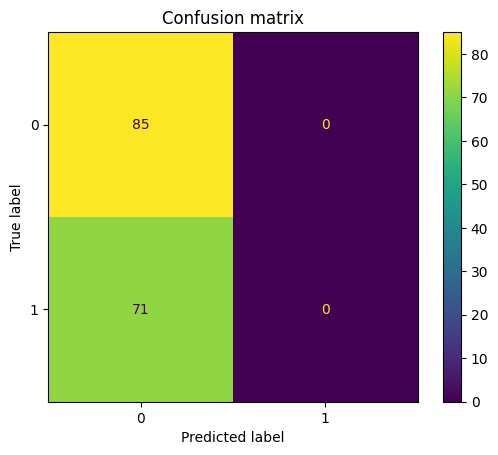

In [65]:
cfn = confusion_matrix(labels, preds)
print(f"Confusion matrix is: {cfn}")
ConfusionMatrixDisplay.from_predictions(labels, preds)
plt.title('Confusion matrix')
plt.show()